# 点云  
本小节介绍一些点云的基本使用方法

In [2]:
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 可视化点云

In [2]:
# 首先需要读取点云
# read_point_cloud可以读取.pcd .ply等点云文件，关于文件IO的内容后面会介绍
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\fragment.pcd') #linux和windows的路径不一样，此处可自行替换路径

# 直接打印pcd会显示点云的个数
print(pcd)

# 打印点的坐标
print(np.asarray(pcd.points))

# 通过draw_geometries函数将点云可视化
o3d.visualization.draw_geometries([pcd], # 需要可视化的点云 注意需要[]括起来
                                  # 以下四个参数是可选项，如果不了解可以不定义，因为可视化窗口可以通过鼠标进行交互的
                                  zoom=0.3412, # 缩放
                                  front=[0.4257, -0.2125, -0.8795], # 一个单位向量，表示相机的正前方方向
                                  lookat=[2.6172, 2.0475, 1.532], # 一个三维坐标点，表示相机注视的目标位置​（即“看向哪里”）
                                  up=[-0.0694, -0.9768, 0.2024]) # 一个单位向量，表示相机的​“头顶”方向，

PointCloud with 113662 points.
[[1.16796875 1.01803279 0.96484375]
 [1.16845131 1.01953125 0.96484375]
 [1.16796875 1.02158833 0.96484375]
 ...
 [2.19495988 2.62890625 1.45703125]
 [2.19140625 2.63435388 1.45703125]
 [2.19140625 2.62890625 1.45781052]]


可视化结果如图所示  
  
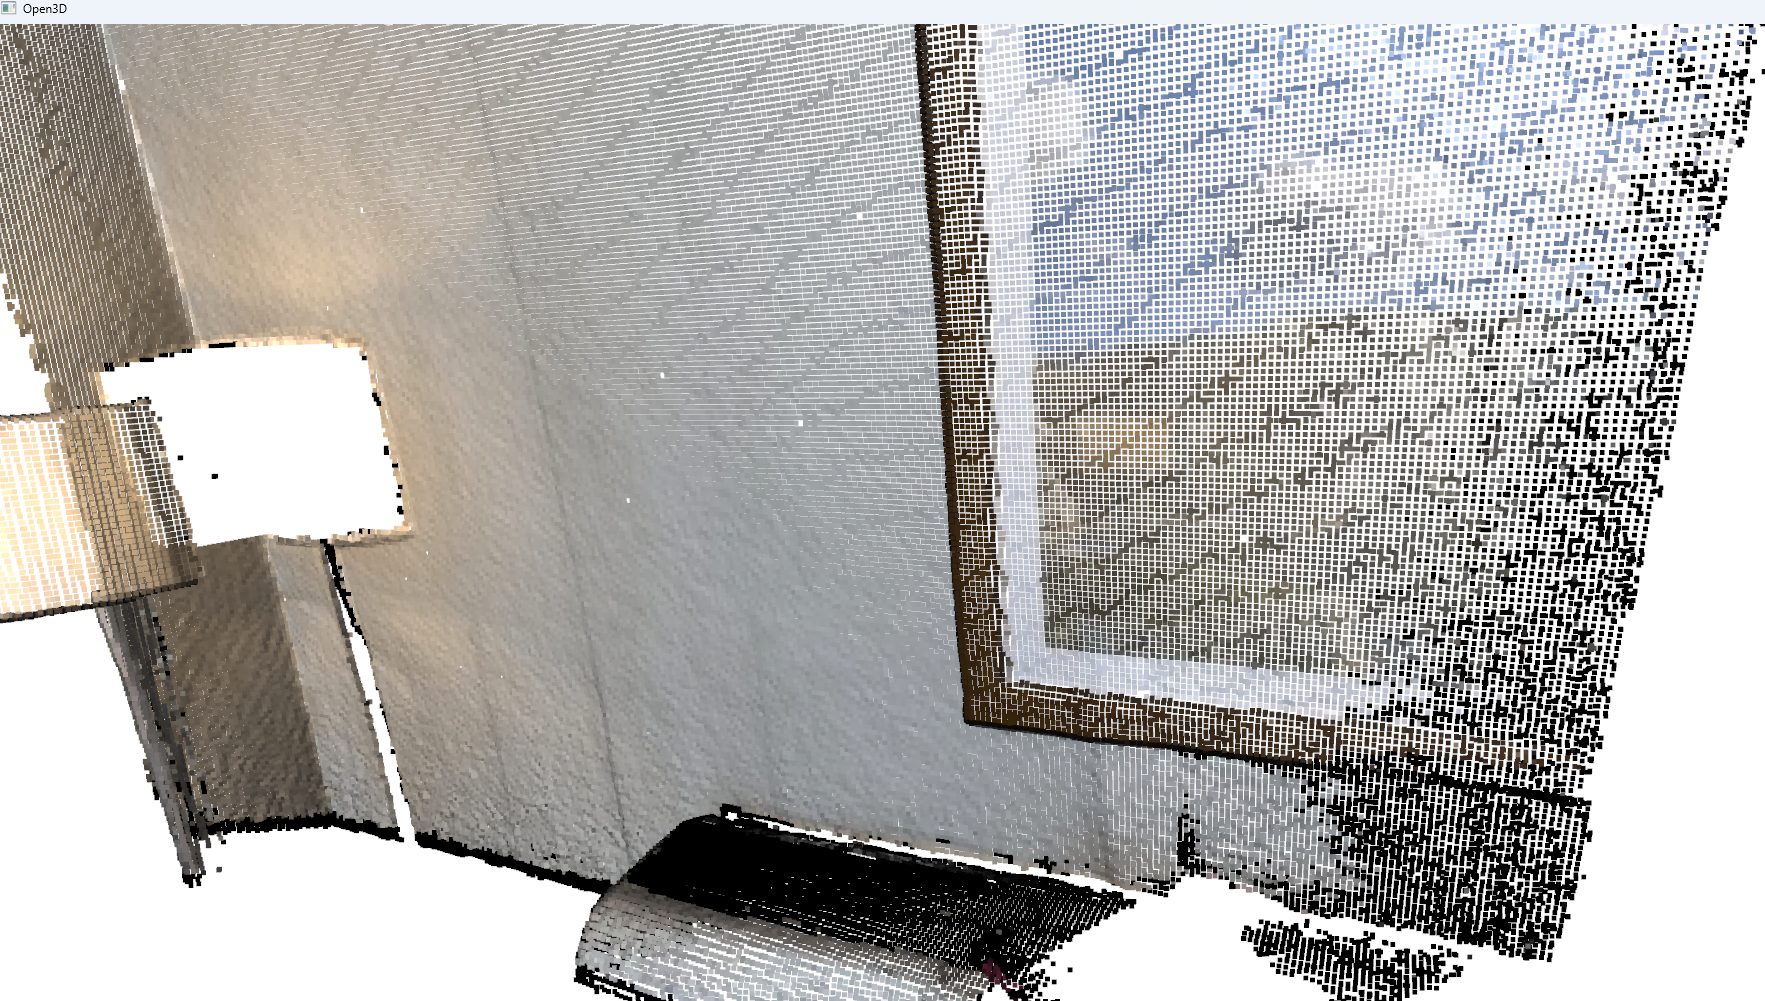

# 体素下采样

体素下采样使用规则体素网格从输入点云中创建均匀下采样的点云，常作为许多点云处理任务的预处理步骤，算法分两步运行  
1.将点放入对应的体素中  
2.通过一定的法则将体素内的多个点下采样成一个点  
tips:如果未来需要学习或研究点云的深度学习，最好了解一下体素的相关知识，目前在点云实例分割中大多数模型都需要将点云体素化，并且稀疏卷积库spconv和MinkowskiEngine都使用体素进行卷积

In [3]:
print("进行体素下采样，体素网格设置成0.05m")
# 调用内置方法.voxel_down_sample()进行体素下采样
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

进行体素下采样，体素网格设置成0.05m


下采样结果如图所示  
  


# 点云法线估计  
法线存在两个相反的方向，无论哪种都是对的。若要指定法线的方向需要使用orient_normals_to_align_with_direction或者orient_normals_towards_camera_location。本例暂不指定法线方向

In [4]:
print("计算下采样后点云的法线")
# 调用内置方法.estimate_normals()进行计算
# 该函数查找每个点一定范围内(即search_param)的相邻点并使用协方差分析计算法线。
# 在本例中，每个点查找在0.1m范围内，相邻的30个点，用以计算法线。使用KDtree可以加快检索速度。
downpcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

o3d.visualization.draw_geometries([downpcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True)

计算下采样后点云的法线


法线结果如图，在可视化界面中，可以通过N键来开关法线的显示，通过-和+控制法线的长短  
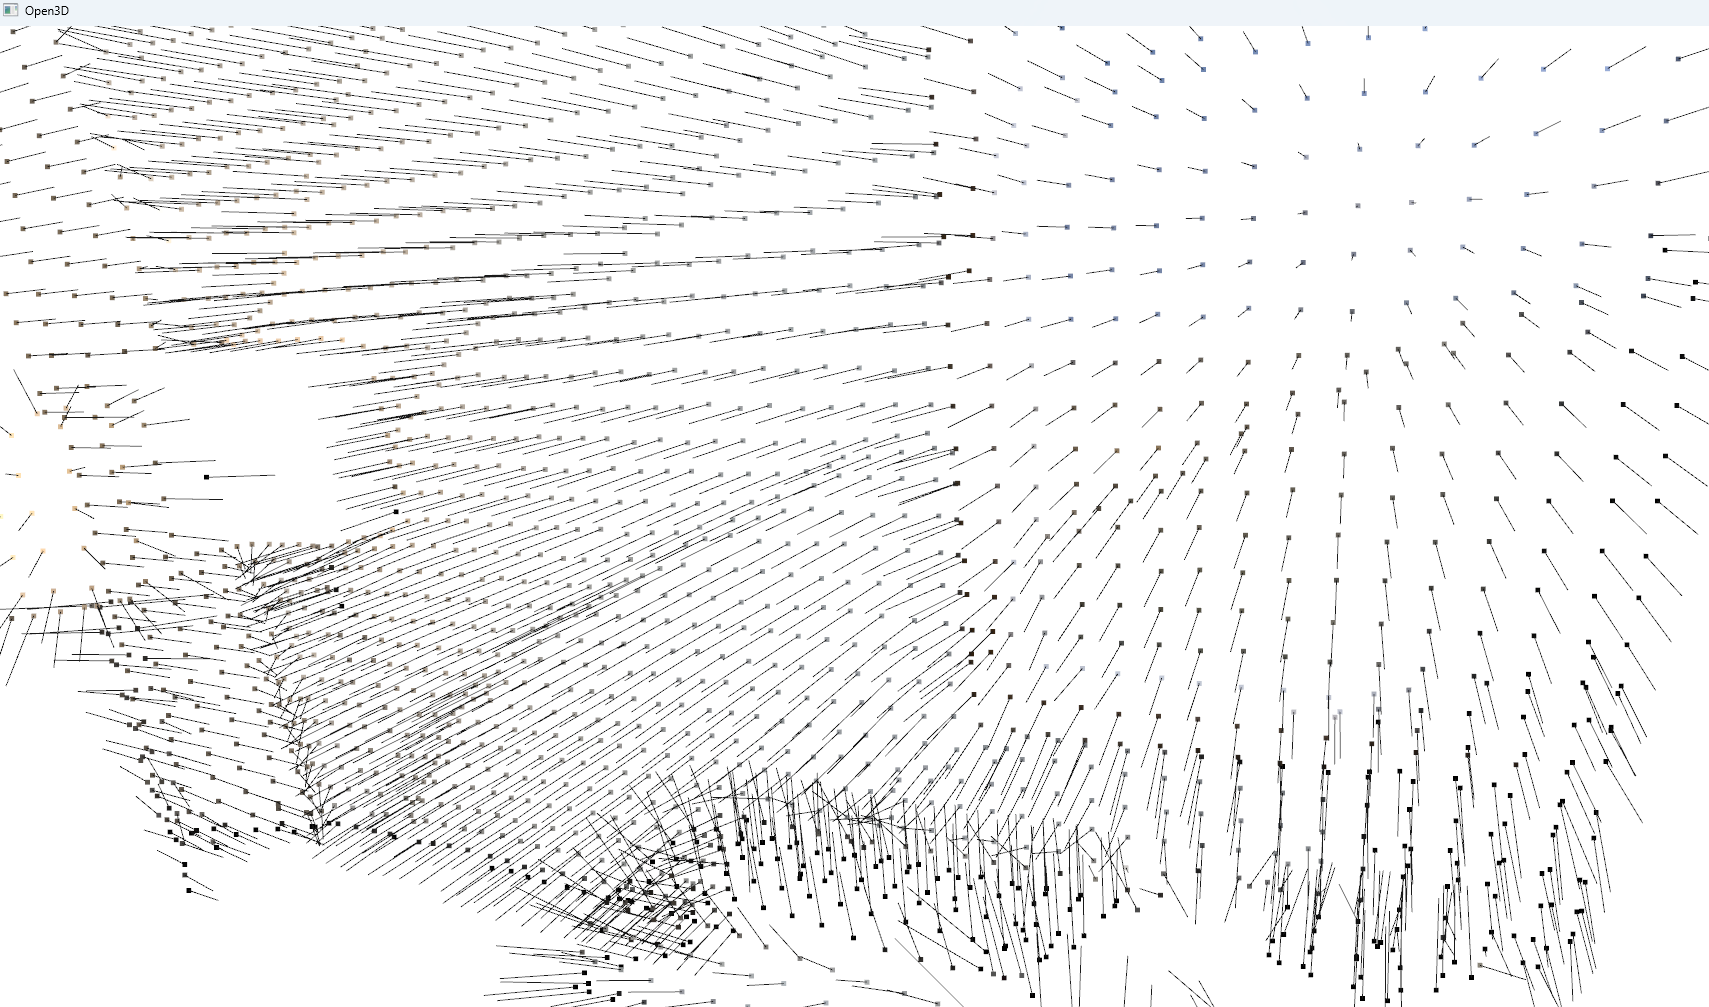

# 读取估计的法向量  
可以通过.normal属性访问点云的法向量

In [5]:
print("第500个点的法向量")
print(downpcd.normals[500])

第500个点的法向量
[ 0.05355466  0.10050433 -0.99349423]


In [ ]:
# 如果需要查看点云还有哪些属性和方法，可以通过如下代码实现
help(downpcd)

In [10]:
print("读取第100至第110各点的法向量，并转换成numpy")
print(np.asarray(downpcd.normals)[100:110, :])

读取第100至第110各点的法向量，并转换成numpy
[[ 0.03097814  0.99675708  0.07426765]
 [-0.03271221 -0.99700229 -0.07011672]
 [ 0.0957096   0.09660595 -0.99071033]
 [ 0.99863314 -0.00770159  0.05169659]
 [ 0.81582181  0.10311295 -0.56903646]
 [ 0.01279277  0.99563498  0.09245178]
 [ 0.16450859  0.83326099 -0.52783809]
 [ 0.66029428  0.06642782 -0.74806337]
 [ 0.00199391  0.9971147   0.07588352]
 [ 0.99978354  0.01161486 -0.01726194]]


# 裁剪点云

In [2]:
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\DemoCropPointCloud\fragment.ply') # 读取点云

vol = o3d.visualization.read_selection_polygon_volume(r'G:\open3d\data\DemoCropPointCloud\cropped.json') #使用read_selection_polygon_volume函数读取包含裁剪范围数据的json文件

chair = vol.crop_point_cloud(pcd) # 根据读取到的裁剪范围对点云进行裁剪

# 可视化
o3d.visualization.draw_geometries([chair],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])


裁剪前 and 裁剪后  
  
  


# 点云着色

In [3]:
# 通过paint_uniform_color()给点云上色
# 注意RGB色彩的取值范围在0-1之间。
chair.paint_uniform_color([0.5, 0.7, 0.3])

o3d.visualization.draw_geometries([chair],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])

可视化结果如图  
  
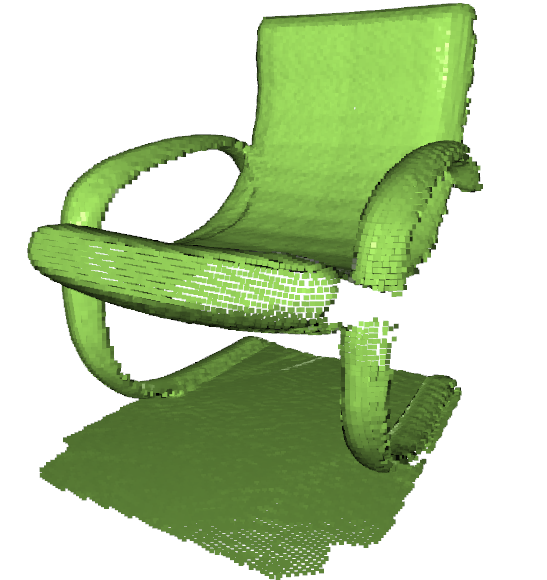

# 点云距离

使用compute_point_cloud_distance函数可以计算源点云和目标点云之间的距离  
也就是计算源点云中每个点到目标点云中最近点的距离(注意源点云和目标点云是两种点云)

In [5]:
# 源点云
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\DemoCropPointCloud\fragment.ply')
vol = o3d.visualization.read_selection_polygon_volume(r'G:\open3d\data\DemoCropPointCloud\cropped.json')
# 裁剪出椅子作为目标点云
chair = vol.crop_point_cloud(pcd)


dists = pcd.compute_point_cloud_distance(chair) #计算源点云至目标点云最近点的距离
dists = np.asarray(dists) # 将距离转换成numpy
print('前十个点的点云距离', dists[:10])

ind = np.where(dists > 0.01)[0] # 获取距离大于0.01的点云索引(小于0.01的点云可以认为与目标点云重合)

pcd_without_chair = pcd.select_by_index(ind) #根据索引使用select_by_index函数将没有椅子的点云筛选出来

# 将筛选后的点云可视化
o3d.visualization.draw_geometries([pcd_without_chair],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

前十个点的点云距离 [1.82659798 1.83171046 1.817216   1.82036216 1.82531345 1.81097216
 1.85466728 1.84636823 1.83745819 1.83837961]


可视化结果如图  
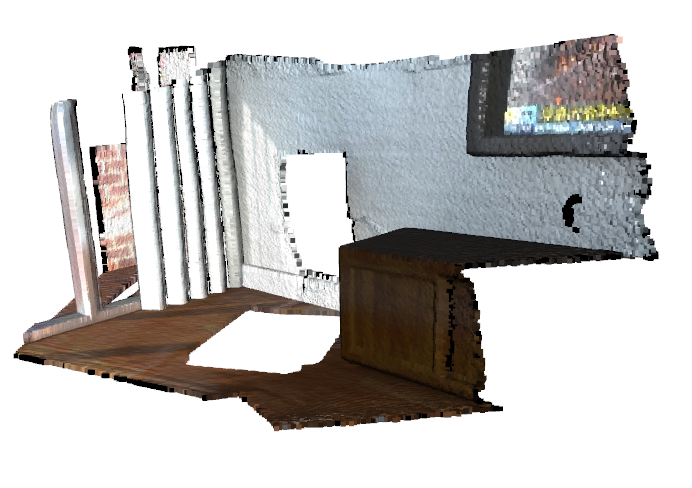

# 包围盒

包围盒有两种类型，AABB(AxisAlignedBoundingBox)包围盒和OBB(OrientedBoundingBox)包围盒  
如果未来从事目标检测方向的可以深入了解一下AABB包围盒

In [6]:
# 使用get_axis_aligned_bounding_box() 计算aabb包围盒
aabb = chair.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0) # 红色

# 使用get_oriented_bounding_box() 计算obb包围盒
obb = chair.get_oriented_bounding_box()
obb.color = (0, 1, 0) # 绿色

# 将包围盒可视化
o3d.visualization.draw_geometries([chair, aabb, obb], # 如果要在一个图层里面显示不同的要素，将用[]将要显示的要素括在一起
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])

包围盒如图所示  
  
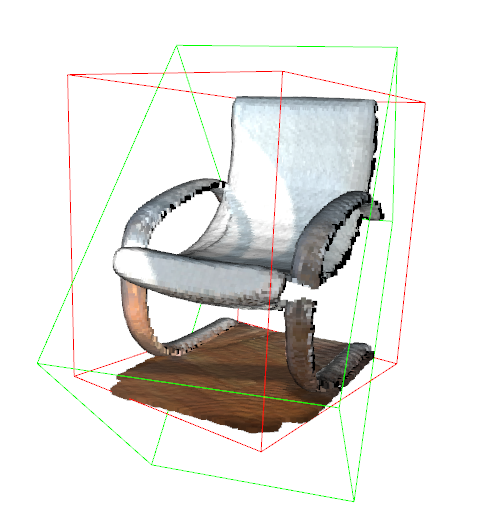

# 凸包

点云的凸包是包含所有点的最小凸集。

In [3]:
# 这里读取的ply有额外的三角网信息
mesh = o3d.io.read_triangle_mesh(r'G:\open3d\data\BunnyMesh.ply') 

# compute_vertex_normals为计算三角网顶点法线的函数，与estimate_normals不同，因为ply文件提供了三角网信息
mesh.compute_vertex_normals()

# sample_points_poisson_disk是一个对点云进行采样的函数，number_of_points=2000表示将点云采样至2000各点
pcl = mesh.sample_points_poisson_disk(number_of_points=2000)

# 使用compute_convex_hull计算凸包，并返回一个open3d.geometry.TriangleMesh对象
hull, _ = pcl.compute_convex_hull()

# 根据open3d.geometry.TriangleMesh对象在3D空间中创建一组线
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0)) #将线赋值为红色
o3d.visualization.draw_geometries([pcl, hull_ls]) #将凸包可视化

凸包如图所示  
  
  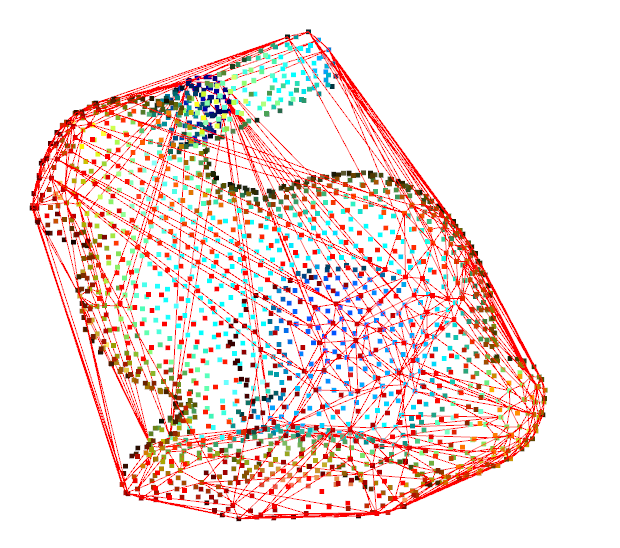

# DBSCAN聚类

DBSCAN是一种基于密度的聚类算法。算法详情可以参考 https://www.biaodianfu.com/dbscan.html  
该算法在open3d中使用cluster_dbscan实现，需要两个参数：eps定义到集群中邻居的距离，min_points定义形成集群所需的最小点数，函数返回标签，其中标签-1表示噪声。

In [5]:
import matplotlib.pyplot as plt
# 读取数据
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\fragment.ply')

# 对点云进行DBSCAN聚类，返回标签值，并将标签转换为nunpy数组。print_progress为是否需要将聚类过程输出至控制台上
labels = np.array(pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True))

# 计算总共有多少个类别
max_label = labels.max()
print(f"该点云有{max_label + 1}个类别")

# 对不同类别点云上色 噪声点则没有颜色
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

# 聚类结果可视化
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

该点云有10个类别


聚类结果可视化  
  
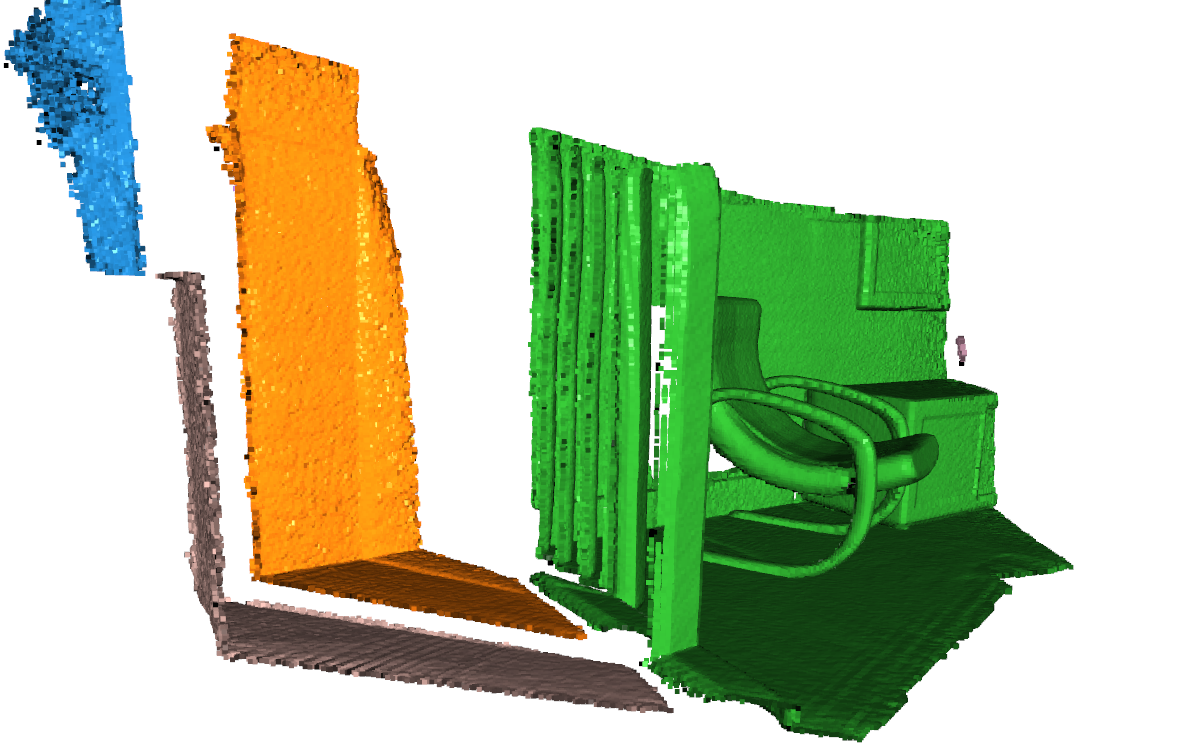

# 平面分割

使用segment_plane可以分割点云中的平面，此方法是基于RANSAC(即随机采样一致，RAndom SAmple Consensus)。基本原理可参考 https://blog.csdn.net/qq_28087491/article/details/107376740

使用segment_plane需要设定三个参数。distance_threshold确定一个阈值，如果一个点到估计平面的距离小于该阈值则被认为是内点。ransac_n为在每次迭代中被认为是内点的初始点数。num_iterations定义需要迭代多少次

segment_plane会返回两个结果。第一个结果返回值为(a,b,c,d)，代表着空间平面方程ax+by+cz+d=0的四个参数。第二个返回结果为内点的索引

In [3]:
# 读取数据
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\fragment.pcd')

# 使用内置方法segment_plane分割平面
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, # 距离阈值设定为0.01
                                         ransac_n=3, # 选取3各点作为初始内点用以估计平面
                                         num_iterations=1000) # 迭代1000次

#读取空间平面参数a b c d 并打印
[a, b, c, d] = plane_model 
print(f"平面方程: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

# 选取内点 并标记内点为红色
inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])

# 选择外点
outlier_cloud = pcd.select_by_index(inliers, invert=True)

# 将内外点一齐可视化
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

平面方程: -0.06x + -0.10y + 0.99z + -1.05 = 0


平面分割结果如图  
  
  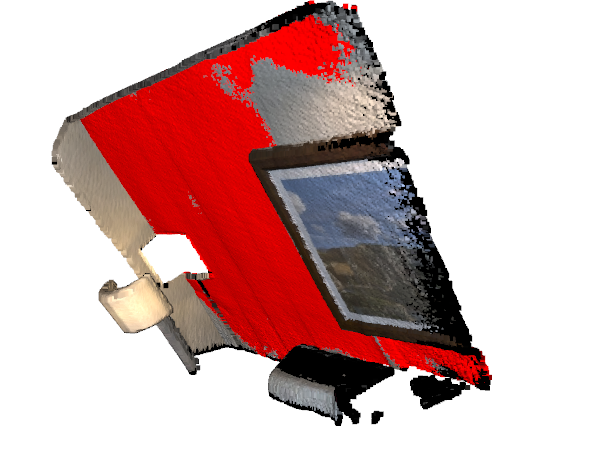